# Synthetic Data Generation Baseline

In [515]:
import os, sys
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
import pickle
import sklearn
import tqdm.notebook as tqdm

from sklearn.model_selection import train_test_split
sns.set_theme()
sys.path.append(os.path.abspath('..'))

torch.backends.cudnn.benchmark = True

In [516]:
%load_ext autoreload
%autoreload 2

from lib.vae_models import VAE, CVAE
import lib.datasets as datasets
import lib.utils as utils
from lib.lda_lib import EntityEncoder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import Data

In [517]:
DATASET_NAME = 'goi4_dp_full_Gipuzkoa'
RANDOM_SEED = 2112
np.random.seed(RANDOM_SEED)

In [518]:
df = pd.read_csv(f'../data/{DATASET_NAME}/dataset.csv')
data, dates, users = df.iloc[:,:-2].values, df.date.values, df.user.values
date_ids, user_ids = df.date.unique(), df.user.unique()
num_days, num_users = len(date_ids), len(user_ids)
print(f'Loaded {len(data)} consumption profiles from {num_days} dates and {num_users} users')

Loaded 2522880 consumption profiles from 365 dates and 6912 users


In [519]:
date_dict = np.load(f'../data/{DATASET_NAME}/encode_dict.npy', allow_pickle=True).item()["date_dict"]
date_dict_inv = {v: k for k, v in date_dict.items()}

In [520]:
if not os.path.exists(f'../data/{DATASET_NAME}/raw_dates.npy'):
    raw_dates = np.array([datetime.datetime.strptime(date_dict_inv[d], '%Y-%m-%d') for d in dates])
    np.save(f'../data/{DATASET_NAME}/raw_dates.npy', raw_dates)
else:
    raw_dates = np.load(f'../data/{DATASET_NAME}/raw_dates.npy', allow_pickle=True)

In [521]:
metadata = pd.read_csv(f'../data/{DATASET_NAME}/metadata.csv')

In [522]:
unique_provinces = metadata.province.unique()
print(f'Loaded metadata for {len(unique_provinces)} provinces')
print(f"Uniqe provinces are: {unique_provinces}")

Loaded metadata for 1 provinces
Uniqe provinces are: ['Gipuzkoa']


### Prepare Conditions

In [523]:
months = np.array([d.month for d in raw_dates])
weekdays = np.array([d.weekday() for d in raw_dates])
is_weekend = np.array([int(d.weekday() >= 5) for d in raw_dates])

In [524]:
df_temp = pd.read_csv(f'../data/{DATASET_NAME}/spain_temp_daily.csv')
df_temp.index = pd.to_datetime(df_temp['date'])
df_temp.drop(columns='date', inplace=True)
df_temp = df_temp.loc[raw_dates]

In [525]:
df_prec = pd.read_csv(f'../data/{DATASET_NAME}/spain_prec_daily.csv')
df_prec.index = pd.to_datetime(df_prec['date'])
df_prec.drop(columns='date', inplace=True)
df_prec = df_prec.loc[raw_dates]
df_prec = df_prec.sort_values(by='prec_total')

In [526]:
condition_kwargs = {}

In [527]:
ADD_MONTHS = True
ADD_WEEKDAYS = True
ADD_IS_WEEKEND = False
ADD_TEMPERATURE_MIN = False
ADD_TEMPERATURE_MAXDELTA = False
ADD_PRECIPITATION_LEVEL = False

condition_kwargs["tags"], condition_kwargs["types"], condition_kwargs["supports"], condition_set  = [], [], [], {}
if ADD_MONTHS: 
    condition_kwargs["tags"].append("months")
    condition_kwargs["types"].append("circ")
    condition_kwargs["supports"].append(np.unique(months).tolist())
    condition_set["months"] = months[...,None]
if ADD_WEEKDAYS: 
    condition_kwargs["tags"].append("weekdays")
    condition_kwargs["types"].append("circ")
    condition_kwargs["supports"].append(np.unique(weekdays).tolist())
    condition_set["weekdays"] = weekdays[...,None]
if ADD_IS_WEEKEND:
    condition_kwargs["tags"].append("is_weekend")
    condition_kwargs["types"].append("cat")
    condition_kwargs["supports"].append([0, 1])
    condition_set["is_weekend"] = is_weekend[...,None]
if ADD_TEMPERATURE_MIN:
    condition_kwargs["tags"].append("temp_min")
    condition_kwargs["types"].append("cont")
    condition_kwargs["supports"].append([df_temp[condition_kwargs["tags"][-1]].min(), df_temp[condition_kwargs["tags"][-1]].max()])
    condition_set["temp_min"] = df_temp[condition_kwargs["tags"][-1]].values[...,None]
if ADD_TEMPERATURE_MAXDELTA:
    condition_kwargs["tags"].append("temp_max_delta")
    condition_kwargs["types"].append("cont")
    condition_kwargs["supports"].append([df_temp[condition_kwargs["tags"][-1]].min(), df_temp[condition_kwargs["tags"][-1]].max()])
    condition_set["temp_max_delta"] = df_temp[condition_kwargs["tags"][-1]].values[...,None]
if ADD_PRECIPITATION_LEVEL:
    condition_kwargs["tags"].append("precipitation_level")
    condition_kwargs["types"].append("ord")
    condition_kwargs["supports"].append(np.unique(df_prec["label"]).tolist())
    condition_set["precipitation_level"] = df_prec["label"].values[...,None]


In [528]:
conditioner = datasets.Conditioner(**condition_kwargs, condition_set=condition_set)

#### Set Resolution

In [529]:
RESOLUTION = 1 #in hours

if RESOLUTION == 12:
    X = np.reshape(data, (-1, 24))
    X = np.reshape(np.concatenate([X[:,6:], X[:,:6]], axis=-1), (num_users, num_days, int(24/RESOLUTION), int(RESOLUTION))).sum(axis=-1)    #circle shift the last dimension of X
else:
    X = np.reshape(data, (num_users, num_days, int(24/RESOLUTION), int(RESOLUTION))).sum(axis=-1)
    X = np.concatenate((X[:,:-2,-6:], X[:,1:-1,:], X[:,2:,:6]), axis=-1)

condition_set = {k: np.reshape(v, (num_users, num_days, -1)) for k, v in condition_set.items()}
condition_set = {k: v[:,1:-1,:] for k, v in condition_set.items()}

num_days = X.shape[1]

#### Clean Data

In [530]:
nonzero_user_mask = np.sum(np.all(X == 0, axis=2), axis=1) < num_days
print(f'Removing {(~nonzero_user_mask).sum()} users with all-zero consumption profiles')
positive_user_mask = np.sum(np.any(X < 0, axis=2), axis=1) == 0
print(f'Removing {(~positive_user_mask).sum()} users with any-negative consumption profiles')
user_mask = nonzero_user_mask & positive_user_mask
X = X[user_mask]
condition_set = {k: v[user_mask] for k, v in condition_set.items()}

Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles


#### Ampute the Dataset

In [531]:
np.random.seed(RANDOM_SEED)
n, a, b = num_days, 0.85, 10.0
# n, a, b = num_days, 1.0, 1.0
missing_days = np.random.binomial(n, p=np.random.beta(a, b, size=X.shape[0]), size=X.shape[0])
print(f"Mean of missing days: {n*a/(a+b):.2f}")

Mean of missing days: 28.44


In [532]:
X_missing = X.copy().astype(float)
condition_missing = {k: v.copy().astype(float) for k, v in condition_set.items()}

for user in range(X.shape[0]): 
    X_missing[user, :missing_days[user]] = np.nan
    for k in condition_missing.keys():
        condition_missing[k][user, :missing_days[user]] = np.nan

#### Subsample the Dataset

In [533]:
USER_SUBSAMPLE_RATE, DAY_SUBSAMPLE_RATE = 10, 1
X, X_missing = X[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :], X_missing[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :]
condition_set = {k: v[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :] for k, v in condition_set.items()}
condition_missing = {k: v[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :] for k, v in condition_missing.items()}
num_users, num_days, num_features = X.shape
X_gt_list = [X[user, :missing_days[user]]*1 for user in range(num_users)]
X_gt_condition_list = {k: [v[user, :missing_days[user]]*1 for user in range(num_users)] for k, v in condition_set.items()}

print("{:.<40}{:.>5}".format("Number of (subsampled/filtered) users", num_users))
print("{:.<40}{:.>5}".format("Number of (subsampled) days", num_days))
print("{:.<40}{:.>5}".format("Number of (aggregated) features", num_features))

Number of (subsampled/filtered) users.....683
Number of (subsampled) days...............363
Number of (aggregated) features............36


In [540]:
missing_idx_mat  = np.isnan(X_missing).any(2)
missing_num_labels = {"user": missing_idx_mat.sum(1), "day": missing_idx_mat.sum(0) }

In [541]:
X_missing = X_missing.reshape(-1, num_features)
user_ids = np.arange(num_users).repeat(num_days)
conditions_missing = {k: v.reshape(-1, v.shape[-1]) for k, v in condition_missing.items()}
missing_idx = np.isnan(X_missing.sum(1))

#### Prepare the Training Data with Missing Records

In [542]:
SHIFT = 1.0
ZERO_ID = -3
LOG_SPACE = True
nonzero_mean, nonzero_std = utils.zero_preserved_log_stats(X_missing)
X_missing = utils.zero_preserved_log_normalize(X_missing, nonzero_mean, nonzero_std, log_output=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)

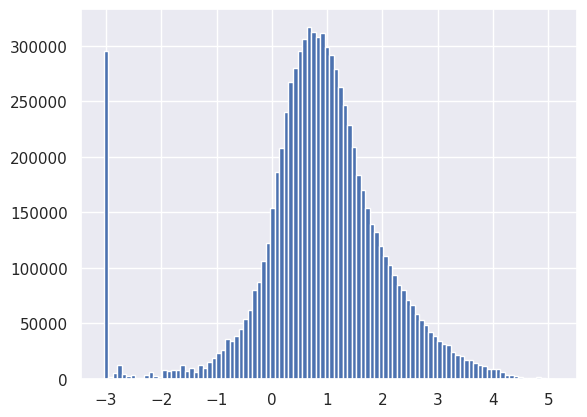

In [543]:
plt.hist(X_missing.flatten(), bins=100)
plt.show()

## User Encodings

In [544]:
NUM_TOPICS = 20
VOCAB_SIZE = 1000
ALPHA = 1.0/NUM_TOPICS
fit_kwargs = {"lda": {'doc_topic_prior': ALPHA,  ## alpha
                      'topic_word_prior': 1.0/VOCAB_SIZE, ## eta
                      'perp_tol': 5e-2, 
                      'max_iter': 10, ## number of epochs
                      'batch_size': 64, 
                      'verbose': True, 
                      'learning_method': 'online', 
                      'evaluate_every': 10,
                      'n_jobs': -1},}

In [545]:
entity_model = EntityEncoder(num_topics=NUM_TOPICS, reduce_dim=False, num_clusters=VOCAB_SIZE, random_state=RANDOM_SEED).fit(X_missing.reshape(num_users, num_days, -1), fit_kwargs)

Clustering...
Init 1/1 with method k-means++
Inertia for init 1/1: 193796.1565824375
[MiniBatchKMeans] Reassigning 379 cluster centers.
Minibatch step 1/2783: mean batch inertia: 7.9171010881714245
Minibatch step 2/2783: mean batch inertia: 7.775153655171167, ewa inertia: 7.775153655171167
[MiniBatchKMeans] Reassigning 123 cluster centers.
Minibatch step 3/2783: mean batch inertia: 7.513461880541572, ewa inertia: 7.756350225491615
Minibatch step 4/2783: mean batch inertia: 7.471919582190428, ewa inertia: 7.73591293200926
[MiniBatchKMeans] Reassigning 36 cluster centers.
Minibatch step 5/2783: mean batch inertia: 7.422816748839175, ewa inertia: 7.71341592356676
Minibatch step 6/2783: mean batch inertia: 7.291118587564908, ewa inertia: 7.683072446884651
[MiniBatchKMeans] Reassigning 37 cluster centers.
Minibatch step 7/2783: mean batch inertia: 7.089445769675096, ewa inertia: 7.640418383734921
Minibatch step 8/2783: mean batch inertia: 7.147265262752146, ewa inertia: 7.604983681804468
[M

In [546]:
user_gamma = entity_model.transform(X_missing.reshape(num_users, num_days, -1))

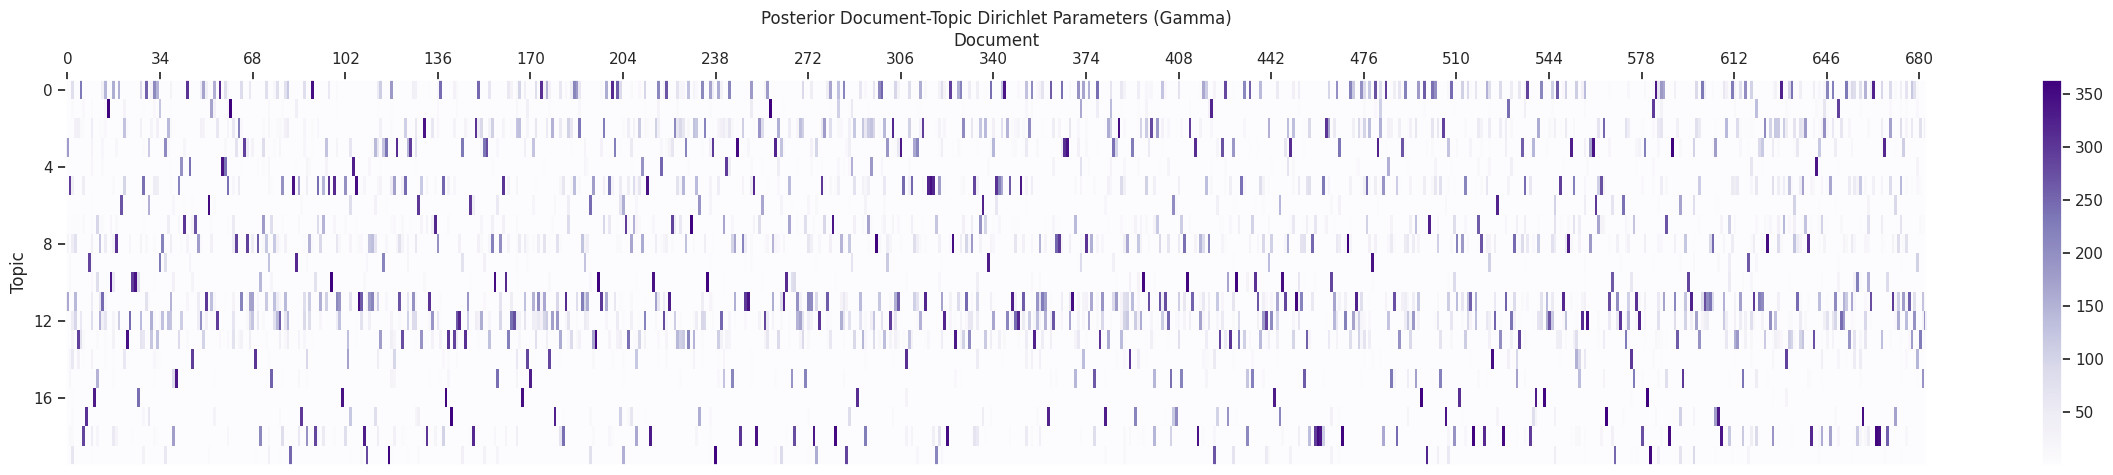

In [547]:
fig, ax = plt.subplots(figsize=(30,5))
im = ax.imshow(user_gamma.T, aspect='auto', cmap='Purples', interpolation='none')
ax.set_title('Posterior Document-Topic Dirichlet Parameters (Gamma)')
ax.set_ylabel('Topic')
ax.set_xlabel('Document')
ax.set_yticks(np.arange(NUM_TOPICS))
ax.set_xticks(np.arange(num_users))
ax.xaxis.tick_top()
ax.yaxis.tick_left()
ax.xaxis.set_label_position('top')
ax.grid(False)
plt.yticks(np.arange(0, NUM_TOPICS, NUM_TOPICS//5))
plt.xticks(np.arange(0, num_users, num_users//20))
fig.colorbar(im, ax=ax)
plt.show()

### Turn embeddings into conditions

In [548]:
conditioner.add_condition(tag="users", typ="dir", support=[ALPHA, entity_model.doc_lengths.max()], data=user_gamma)

In [549]:
conditions_missing["users"] = user_gamma.repeat(num_days, axis=0)

## Ctd

In [550]:
X_missing = X_missing[~missing_idx]
user_ids_missing = user_ids[~missing_idx]
conditions_missing = {k: v[~missing_idx] for k, v in conditions_missing.items()}

In [551]:
## split the X_missing and conditions_missing into training and validation sets
VAL_RATIO = 0.1
random_idx = np.random.permutation(len(X_missing))
val_idx = random_idx[:int(len(X_missing)*VAL_RATIO)]
train_idx = random_idx[int(len(X_missing)*VAL_RATIO):]

X_train, X_val = X_missing[train_idx], X_missing[val_idx]
user_ids_train, user_ids_val = user_ids_missing[train_idx], user_ids_missing[val_idx]
conditions_train = {k: v[train_idx] for k, v in conditions_missing.items()}
conditions_val = {k: v[val_idx] for k, v in conditions_missing.items()}

In [552]:
trainset = datasets.ConditionedDataset(inputs=X_train, conditions=conditions_train, conditioner=conditioner)
valset = datasets.ConditionedDataset(inputs=X_val, conditions=conditions_val, conditioner=conditioner)
print(f"Number of Training Points: {len(trainset)}")
print(f"Number of Validation Points: {len(valset)}")

Number of Training Points: 205218
Number of Validation Points: 22801


### Model

In [598]:
distribution_dict = {"posterior": {"dist_type": "normal",
                                    "learn_sigma": True,
                                    "sigma_lim": 0.1,
                                    "num_neurons": 300,
                                    "num_hidden_layers": 8,
                                    "dropout": False,
                                    "dropout_rate": 0.20,
                                    "batch_normalization": True,
                                    "resnet": True},
                    "likelihood": {"dist_type": "dict-gauss",
                                    "vocab_size": 100,
                                    "learn_sigma": True,
                                    "sigma_lim": 0.01,
                                    "marginal_var_lim": 0.1,
                                    "total_max_std": 3.0, 
                                    "mu_upper_lim": 5.0, 
                                    "mu_lower_lim": ZERO_ID - 1.0,
                                    "sigma_fixed": 0.1,
                                    "num_neurons": 300,
                                    "num_hidden_layers": 7,
                                    "dropout": False,
                                    "dropout_rate": 0.20,
                                    "batch_normalization": True,
                                    "resnet": True}
                    }

In [599]:
model_kwargs = {"latent_dim": 24,
                "condencoding_dim": None,
                "distribution_dict": distribution_dict,
                }

In [600]:
model = CVAE(input_dim=num_features, conditioner=conditioner, **model_kwargs)
print("Number of encoder parameters:", model.encoder._num_parameters())
print("Number of decoder parameters:", model.decoder._num_parameters())

Number of encoder parameters: 1033248
Number of decoder parameters: 965236


### Training

In [297]:
train_kwargs = {
                "lr": 5e-4,
                "beta": 1.0,
                "num_mc_samples": 1,
                "epochs": 1000,
                "verbose_freq": 100,
                "tensorboard": True,
                "batch_size": 1024,
                "validation_freq": 500,
                "device": "cuda:1",
                "tqdm_func": tqdm.tqdm,
                }

In [298]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_kwargs["batch_size"], shuffle=True, drop_last=True, num_workers=1, pin_memory=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=train_kwargs["batch_size"]*8, shuffle=False, drop_last=False, num_workers=4, pin_memory=False)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_kwargs["batch_size"], shuffle=True, drop_last=True)
# valloader = torch.utils.data.DataLoader(valset, batch_size=train_kwargs["batch_size"]*8, shuffle=False, drop_last=False)

In [299]:
torch.cuda.empty_cache()
model.fit(trainloader=trainloader, valloader=valloader, **train_kwargs)

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iteration in Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 100 -- ELBO=-3.65e+01 / RLL=-2.95e+01 / KL=6.95e+00
Iteration: 200 -- ELBO=-3.08e+01 / RLL=-2.41e+01 / KL=6.70e+00
Iteration: 300 -- ELBO=-2.69e+01 / RLL=-2.05e+01 / KL=6.46e+00
Iteration: 400 -- ELBO=-2.72e+01 / RLL=-2.04e+01 / KL=6.74e+00
Validation -- ELBO=-2.52e+01 / RLL=-1.83e+01 / KL=6.88e+00
Iteration: 500 -- ELBO=-2.69e+01 / RLL=-2.00e+01 / KL=6.88e+00
Iteration: 600 -- ELBO=-2.52e+01 / RLL=-1.84e+01 / KL=6.75e+00
Iteration: 700 -- ELBO=-2.48e+01 / RLL=-1.83e+01 / KL=6.54e+00
Iteration: 800 -- ELBO=-2.47e+01 / RLL=-1.78e+01 / KL=6.90e+00
Iteration: 900 -- ELBO=-2.36e+01 / RLL=-1.68e+01 / KL=6.81e+00
Validation -- ELBO=-2.32e+01 / RLL=-1.65e+01 / KL=6.71e+00
Iteration: 1000 -- ELBO=-2.33e+01 / RLL=-1.66e+01 / KL=6.70e+00
Iteration: 1100 -- ELBO=-2.30e+01 / RLL=-1.64e+01 / KL=6.59e+00
Iteration: 1200 -- ELBO=-2.29e+01 / RLL=-1.62e+01 / KL=6.71e+00
Iteration: 1300 -- ELBO=-2.30e+01 / RLL=-1.63e+01 / KL=6.75e+00
Iteration: 1400 -- ELBO=-2.38e+01 / RLL=-1.72e+01 / KL=6.57

KeyboardInterrupt: 

In [300]:
torch.cuda.empty_cache()

In [301]:
model.to("cpu")
model.prior_params = {k: v.to("cpu") for k, v in model.prior_params.items()}
model.eval()

CVAE(
  (encoder): GaussianNN(
    (parameterizer): ParameterizerNN(
      (block_dict): ModuleDict(
        (input): NNBlock(
          (input_layer): Sequential(
            (0): Linear(in_features=60, out_features=300, bias=True)
            (1): Softplus(beta=1.0, threshold=20.0)
            (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (middle_layers): ModuleList(
            (0-7): 8 x Sequential(
              (0): Linear(in_features=300, out_features=300, bias=True)
              (1): Softplus(beta=1.0, threshold=20.0)
              (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
          (output_layer): Sequential(
            (0): Linear(in_features=300, out_features=300, bias=True)
            (1): Softplus(beta=1.0, threshold=20.0)
            (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )

In [302]:
save_path = model.log_dir
model_name = f'trained_model'
model_path = f'./{save_path}/{model_name}.pt'
torch.save(model.state_dict(), model_path)
print(f'Model saved at {model_path}')

Model saved at ./runs/Jul03_12-19-15_iepg-compute1.ewi.tudelft.nl/trained_model.pt


In [303]:
conditioner_path = f'./{save_path}/conditioner.pkl'
with open(conditioner_path, 'wb') as f: pickle.dump(conditioner, f)
print(f'Conditioner saved at {conditioner_path}')

Conditioner saved at ./runs/Jul03_12-19-15_iepg-compute1.ewi.tudelft.nl/conditioner.pkl


## Load the Trained Model (if needed)

In [601]:
LOAD_MODEL = True

model_path = None
conditioner_path = None

## Load the latest model
if model_path is None or conditioner_path is None:
    paths = [f'runs/{f}' for f in os.listdir("runs")]
    latest_path = paths[np.argmax([os.path.getmtime(f) for f in paths])]
    print(f'Loading model from {latest_path}')
    
    model_path = f'{latest_path}/trained_model.pt'
    conditioner_path = f'{latest_path}/conditioner.pkl'

Loading model from runs/Jul03_10-59-22_iepg-compute1.ewi.tudelft.nl


In [602]:
if LOAD_MODEL:
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to("cpu")
    model.prior_params = {k: v.to("cpu") for k, v in model.prior_params.items()}
    model.eval()

    with open(conditioner_path, 'rb') as f: conditioner = pickle.load(f)

    print(f'Model loaded from {model_path}')
    print(f'Conditioner loaded from {conditioner_path}')

Model loaded from runs/Jul03_10-59-22_iepg-compute1.ewi.tudelft.nl/trained_model.pt
Conditioner loaded from runs/Jul03_10-59-22_iepg-compute1.ewi.tudelft.nl/conditioner.pkl


## Inspection

### Sigma Dictionary

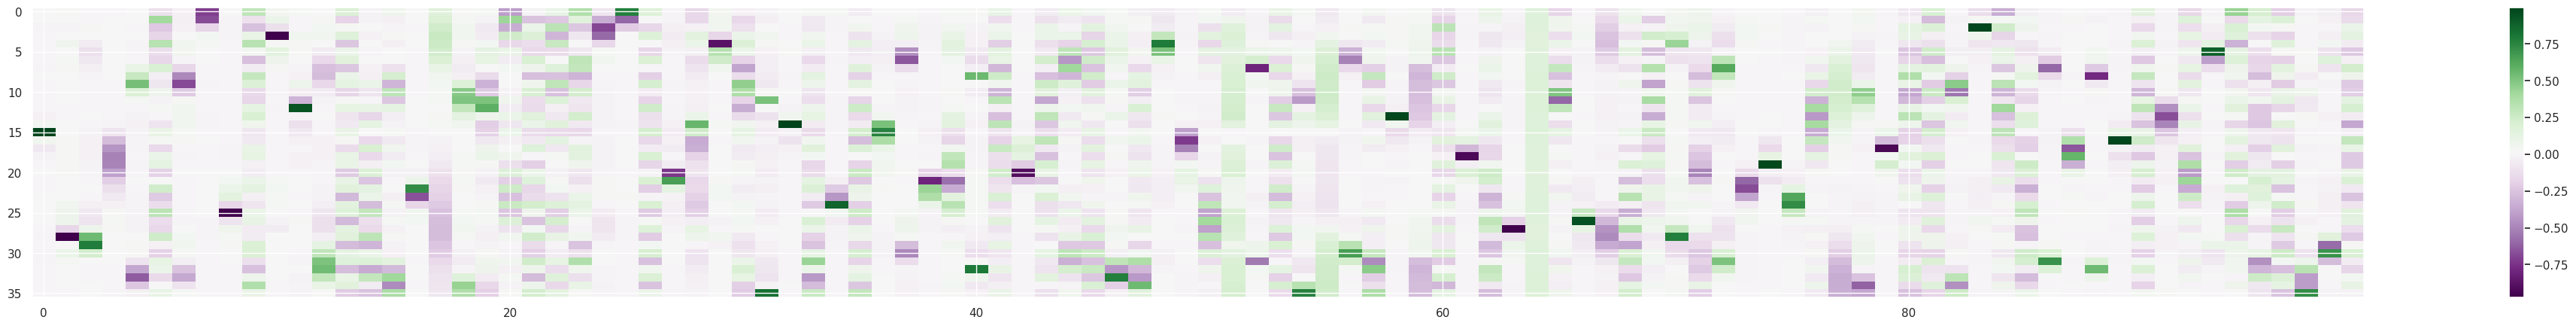

In [603]:
fig, ax = plt.subplots(figsize=(50,5))
im = ax.imshow(model.decoder.get_SigmaMapper().detach().numpy(), aspect='auto', cmap='PRGn', interpolation='none')
fig.colorbar(im, ax=ax)

### Validation Set

In [604]:
x_val = torch.tensor(X_val).float()
x_val_conditions = conditions_val.copy()
x_rec, z_rec = model.reconstruct(x_val, torch.tensor(conditioner.transform(x_val_conditions)).float())

In [605]:
x_rec_mu = x_rec["params"]["mu"].detach().squeeze(0)
x_rec_sigma = model.decoder.get_marginal_sigmas(x_rec["params"]).detach().squeeze(0)

x_val_Sigma = model.decoder.create_covariance_matrix(x_rec["params"]).squeeze(0).detach()
x_val_Corr = x_val_Sigma / (x_rec_sigma[...,None]*x_rec_sigma[:,None,:])

x_val_denorm = utils.zero_preserved_log_denormalize(x_val.unsqueeze(0), nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()
x_rec_denorm = utils.zero_preserved_log_denormalize(x_rec_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()
x_rec_denorm_sigma_low = utils.zero_preserved_log_denormalize(x_rec_mu - 2*x_rec_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()
x_rec_denorm_sigma_high = utils.zero_preserved_log_denormalize(x_rec_mu + 2*x_rec_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()

Top-5 Mimimum RLL: [-565.68555 -289.80902 -182.5416  -154.2272  -130.56476] (Data index: [15179 10784 16413  6438  8304])
Top-5 Maximum KL: [16.798779 17.208654 18.676659 19.222221 21.365557] (Data index: [ 2309 15596 11368  8151 13246])


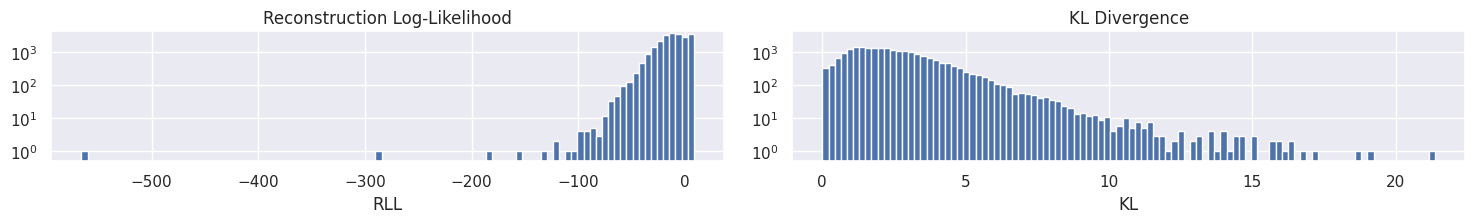

In [606]:
rll_val = model.reconstruction_loglikelihood(x_val, x_rec["params"]).detach().numpy()
kl_val = model.kl_divergence(z_rec["params"], prior_params=model.prior_params).detach().numpy()

print(f"Top-5 Mimimum RLL: {np.sort(rll_val)[:5]} (Data index: {np.argsort(rll_val)[:5]})")
print(f"Top-5 Maximum KL: {np.sort(kl_val)[-5:]} (Data index: {np.argsort(kl_val)[-5:]})")
fig, ax = plt.subplots(1,2, figsize=(15,2))
fig.tight_layout()
h_rll = ax[0].hist(rll_val, bins=100, log=True)
ax[0].set_title("Reconstruction Log-Likelihood")
ax[0].set_xlabel("RLL")
h_kl = ax[1].hist(kl_val, bins=100, log=True)
ax[1].set_title("KL Divergence")
ax[1].set_xlabel("KL")
ax[0].set_ylim(0.5, max(h_rll[0].max(), h_kl[0].max())*1.1)
ax[1].set_ylim(0.5, max(h_rll[0].max(), h_kl[0].max())*1.1)
plt.show()

Top-5 Mimimum Log10-Det: [-35.95664 -35.95664 -35.95664 -35.95664 -35.95664] (Data index: [15849, 16785, 4889, 18709, 16019])
Top-5 Maximum Log10-Det: [ 8.776666  8.800187  9.977859 11.404318 13.350844] (Data index: [19407, 6613, 8674, 2683, 10637])
Top-5 Minimum Total Variance: [3.6100001 3.6100001 3.6100001 3.6100001 3.6100001] (Data index: [11589, 16918, 16933, 16955, 4955])
Top-5 Maximum Total Variance: [83.285065 86.27744  88.78016  89.99094  98.77505 ] (Data index: [8674, 2683, 3990, 1112, 10637])


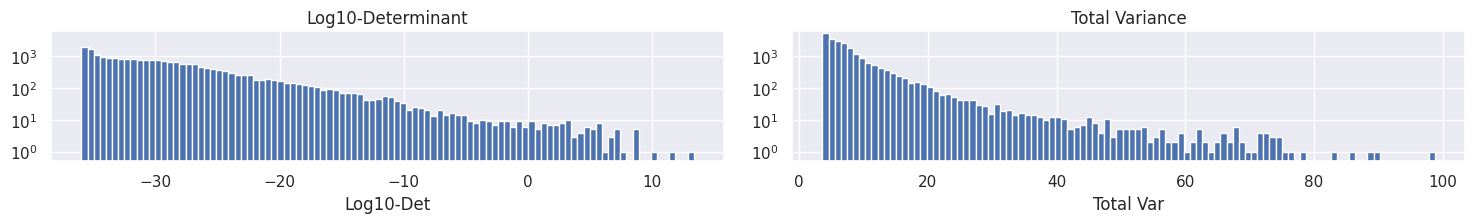

In [607]:
x_val_log10det = x_val_Sigma.logdet() * np.log10(np.e)
x_val_total_var = torch.diagonal(x_val_Sigma, dim1=-1, dim2=-2).sum(-1)

print(f"Top-5 Mimimum Log10-Det: {np.sort(x_val_log10det)[:5]} (Data index: {np.argsort(x_val_log10det)[:5].tolist()})")
print(f"Top-5 Maximum Log10-Det: {np.sort(x_val_log10det)[-5:]} (Data index: {np.argsort(x_val_log10det)[-5:].tolist()})")
print(f"Top-5 Minimum Total Variance: {np.sort(x_val_total_var)[:5]} (Data index: {np.argsort(x_val_total_var)[:5].tolist()})")
print(f"Top-5 Maximum Total Variance: {np.sort(x_val_total_var)[-5:]} (Data index: {np.argsort(x_val_total_var)[-5:].tolist()})")

fig, ax = plt.subplots(1,2, figsize=(15,2))
fig.tight_layout()
h_logdet = ax[0].hist(x_val_log10det, bins=100, log=True)
ax[0].set_title("Log10-Determinant")
ax[0].set_xlabel("Log10-Det")
h_corr = ax[1].hist(x_val_total_var, bins=100, log=True)
ax[1].set_title("Total Variance")
ax[1].set_xlabel("Total Var")
ax[0].set_ylim(0.5, max(h_logdet[0].max(), h_corr[0].max())*1.1)
ax[1].set_ylim(0.5, max(h_logdet[0].max(), h_corr[0].max())*1.1)
plt.show()


#### Inspect a specific validation data point

In [608]:
val_data_idx = 15179

print(f"User ID: {user_ids_val[val_data_idx]}")
print("*"*25)
print("{:<20}{:>5}".format("Condition", "Value"))
print("="*25)
for k, v in x_val_conditions.items():
    print(f"{k:<20}" + " ".join([f"{x:.2f}" for x in v[val_data_idx]]))

User ID: 555
*************************
Condition           Value
months              12.00
weekdays            3.00
users               0.05 0.05 0.05 0.05 0.05 0.05 0.05 43.72 28.22 0.05 0.98 0.05 0.05 0.05 94.06 136.07 0.05 0.05 12.26 0.05


In [609]:
print(f"Reconstruction Log-Likelihood: {rll_val[val_data_idx]}")
print("*"*100)
print(f"KL Divergence: {kl_val[val_data_idx]}")
print("*"*100)
print(f"Log10-Determinant: {x_val_log10det[val_data_idx]}")
print("*"*100)
print(f"Eigenvalues: {torch.linalg.eigvalsh(x_val_Sigma[val_data_idx])}")
print("*"*100)
print(f"Total Variance: {x_val_total_var[val_data_idx]}")
print("*"*100)
print(f"Marginal Variances: {x_val_Sigma[val_data_idx].diag().detach()}")
print("*"*100)
print(f"sigma values: {x_rec['params']['sigma'][0,val_data_idx]}")

Reconstruction Log-Likelihood: -565.685546875
****************************************************************************************************
KL Divergence: 13.842620849609375
****************************************************************************************************
Log10-Determinant: -32.784969329833984
****************************************************************************************************
Eigenvalues: tensor([0.1002, 0.1002, 0.1002, 0.1002, 0.1002, 0.1002, 0.1002, 0.1002, 0.1002,
        0.1003, 0.1003, 0.1003, 0.1003, 0.1003, 0.1003, 0.1003, 0.1003, 0.1003,
        0.1004, 0.1004, 0.1009, 0.1011, 0.1025, 0.1051, 0.1081, 0.1096, 0.1111,
        0.1182, 0.1322, 0.1355, 0.1461, 0.1922, 0.2264, 0.2487, 0.4128, 0.7780])
****************************************************************************************************
Total Variance: 5.133877754211426
****************************************************************************************************
Marginal

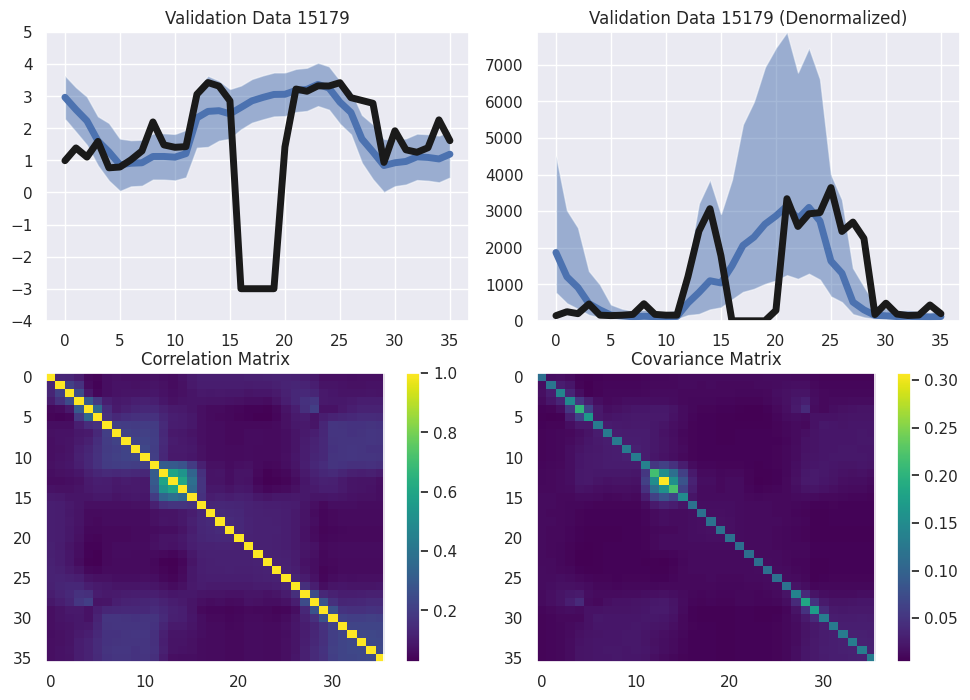

In [610]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
fig.tight_layout()
ax[0,0].plot(x_rec_mu[val_data_idx].detach().numpy(), lw=5)
ax[0,0].fill_between(np.arange(x_rec_mu.shape[1]), (x_rec_mu-2*x_rec_sigma)[val_data_idx], (x_rec_mu+2*x_rec_sigma)[val_data_idx], alpha=0.5)
ax[0,0].plot(x_val[val_data_idx].numpy(), lw=5, color='k')
ax[0,0].set_title(f"Validation Data {val_data_idx}")
ax[0,0].set_ylim(-4, 5)

ax[0,1].plot(x_rec_denorm[val_data_idx].T, lw=5)
ax[0,1].fill_between(np.arange(x_rec_denorm.shape[1]), x_rec_denorm_sigma_low[val_data_idx], x_rec_denorm_sigma_high[val_data_idx], alpha=0.5)
ax[0,1].plot(x_val_denorm[val_data_idx].T, lw=5, color='k')
ax[0,1].set_title(f"Validation Data {val_data_idx} (Denormalized)")
ax[0,1].set_ylim(0, max(x_rec_denorm_sigma_high[val_data_idx].max(),500))

im = ax[1,0].imshow(x_val_Corr[val_data_idx], aspect='auto', cmap='viridis', interpolation='nearest')
ax[1,0].set_title(f"Correlation Matrix")
ax[1,0].grid(False)
plt.colorbar(im)

im = ax[1,1].imshow(x_val_Sigma[val_data_idx], aspect='auto', cmap='viridis', interpolation='none')
ax[1,1].set_title(f"Covariance Matrix")
ax[1,1].grid(False)
plt.colorbar(im)
plt.show()

### Validation subset and reconstruction samples

In [611]:
num_subsamples, num_rec_samples = 5, 1
random_idx = np.random.choice(len(X_val), num_subsamples, replace=False)

In [612]:
samples = model.decoder.sample({k: v[0,random_idx] for k, v in x_rec["params"].items()},num_samples=num_rec_samples).detach()
samples_denorm = utils.zero_preserved_log_denormalize(samples, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)

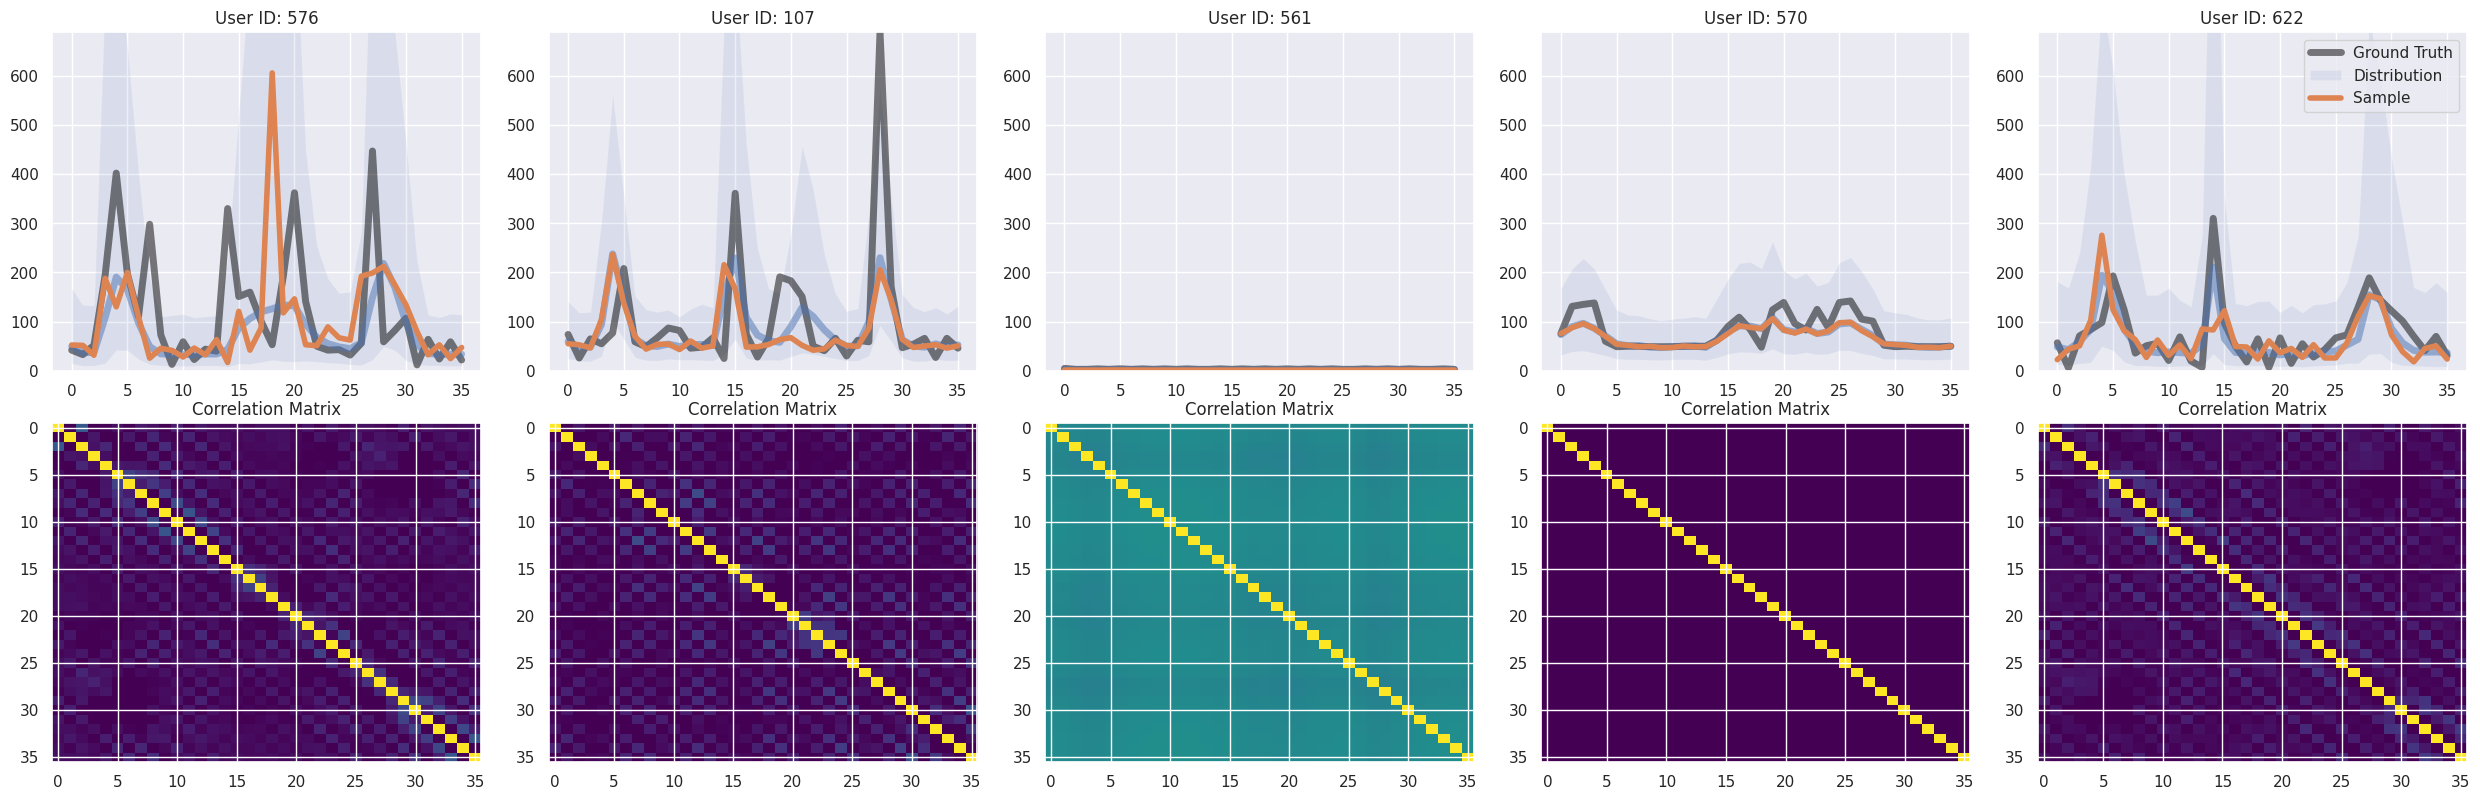

In [613]:
fig, ax = plt.subplots(2, 5, figsize=(25, 8))
fig.tight_layout()
for i in range(5):
    ax[0,i].plot(x_val_denorm[random_idx[i]].T, lw=5, alpha=0.5, color='black', label='Ground Truth')
    ax[0,i].plot(x_rec_denorm[random_idx[i]].T, lw=5, alpha=0.5)
    ax[0,i].fill_between(np.arange(x_val_denorm.shape[1]), x_rec_denorm_sigma_low[random_idx[i]].T, x_rec_denorm_sigma_high[random_idx[i]].T, alpha=0.1, label="Distribution")
    ax[0,i].plot(samples_denorm[:,i,:].squeeze().T, lw=4, label='Sample')
    ax[0,i].set_ylim([0, np.max(x_val_denorm[random_idx]).item()])
    ax[0,i].set_title(f"User ID: {user_ids_val[random_idx[i]]}")

    im = ax[1,i].imshow(x_val_Corr[random_idx[i]], aspect='auto', cmap='viridis', interpolation='none', vmin=0, vmax=1)
    ax[1,i].set_title(f"Correlation Matrix")
ax[0,-1].legend()
plt.show()

### Random sample

In [614]:
random_condition_set, random_conditions = conditioner.get_random_conditions(1)
random_user_idx = np.random.choice(user_gamma.shape[0])
random_conditions["users"] = user_gamma[[random_user_idx]]
random_condition_set =  conditioner.transform(random_conditions)

print(f"User ID: {random_user_idx}")
print(f"*"*25)
print("{:<20}{:>5}".format("Condition", "Value"))
print("="*25)
for k, v in random_conditions.items():
    print(f"{k:<20}" + " ".join([f"{x:.2f}" for x in v[0]]))

User ID: 628
*************************
Condition           Value
months              2.00
weekdays            1.00
users               0.05 0.05 114.92 7.47 0.05 39.87 0.05 31.31 87.46 0.05 0.05 34.52 0.05 23.52 1.10 0.05 0.05 0.05 2.28 0.05


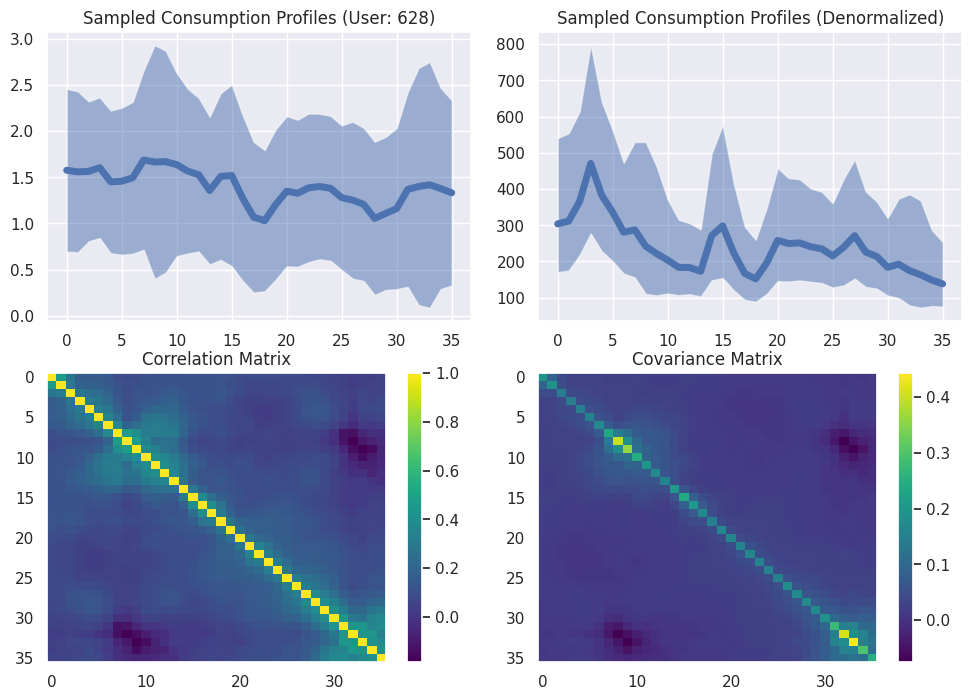

In [615]:
x_sample = model.sample(condition=torch.tensor(random_condition_set).float(), num_samples_prior=1, num_samples_likelihood=1)
x_mu = x_sample["params"]["mu"].detach()
x_sigma = model.decoder.get_marginal_sigmas(x_sample["params"]).detach()
x_mu_denorm = utils.zero_preserved_log_denormalize(x_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_sigma_upper_denorm = utils.zero_preserved_log_denormalize(x_mu+x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_sigma_lower_denorm = utils.zero_preserved_log_denormalize(x_mu-x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_Sigma = model.decoder.create_covariance_matrix(x_sample["params"]).detach()
x_Corr = x_Sigma/ (x_sigma[...,None]*x_sigma[:,None,:])

fig, ax = plt.subplots(2, 2, figsize=(10, 7))
fig.tight_layout()
ax[0,0].plot(x_mu.T, lw=5)
ax[0,0].fill_between(np.arange(x_mu.shape[1]), (x_mu-2*x_sigma)[0], (x_mu+2*x_sigma)[0], alpha=0.5)
ax[0,0].set_title(f"Sampled Consumption Profiles (User: {random_user_idx})")
ax[0,1].plot(x_mu_denorm.T, lw=5)
ax[0,1].fill_between(np.arange(x_mu_denorm.shape[1]), x_sigma_lower_denorm[0], x_sigma_upper_denorm[0], alpha=0.5)
ax[0,1].set_title("Sampled Consumption Profiles (Denormalized)")
im = ax[1,0].imshow(x_Corr[0], aspect='auto', cmap='viridis', interpolation='nearest')
ax[1,0].set_title(f"Correlation Matrix")
ax[1,0].grid(False)
plt.colorbar(im)
im = ax[1,1].imshow(x_Sigma[0], aspect='auto', cmap='viridis', interpolation='none')
ax[1,1].set_title(f"Covariance Matrix")
ax[1,1].grid(False)
plt.colorbar(im)
plt.show()

## Inspection for a specific user

### Reconstruction samples

In [616]:
user_id_selected = 0
random_idx = np.random.choice(np.where(user_ids_val == user_id_selected)[0], num_subsamples, replace=False)

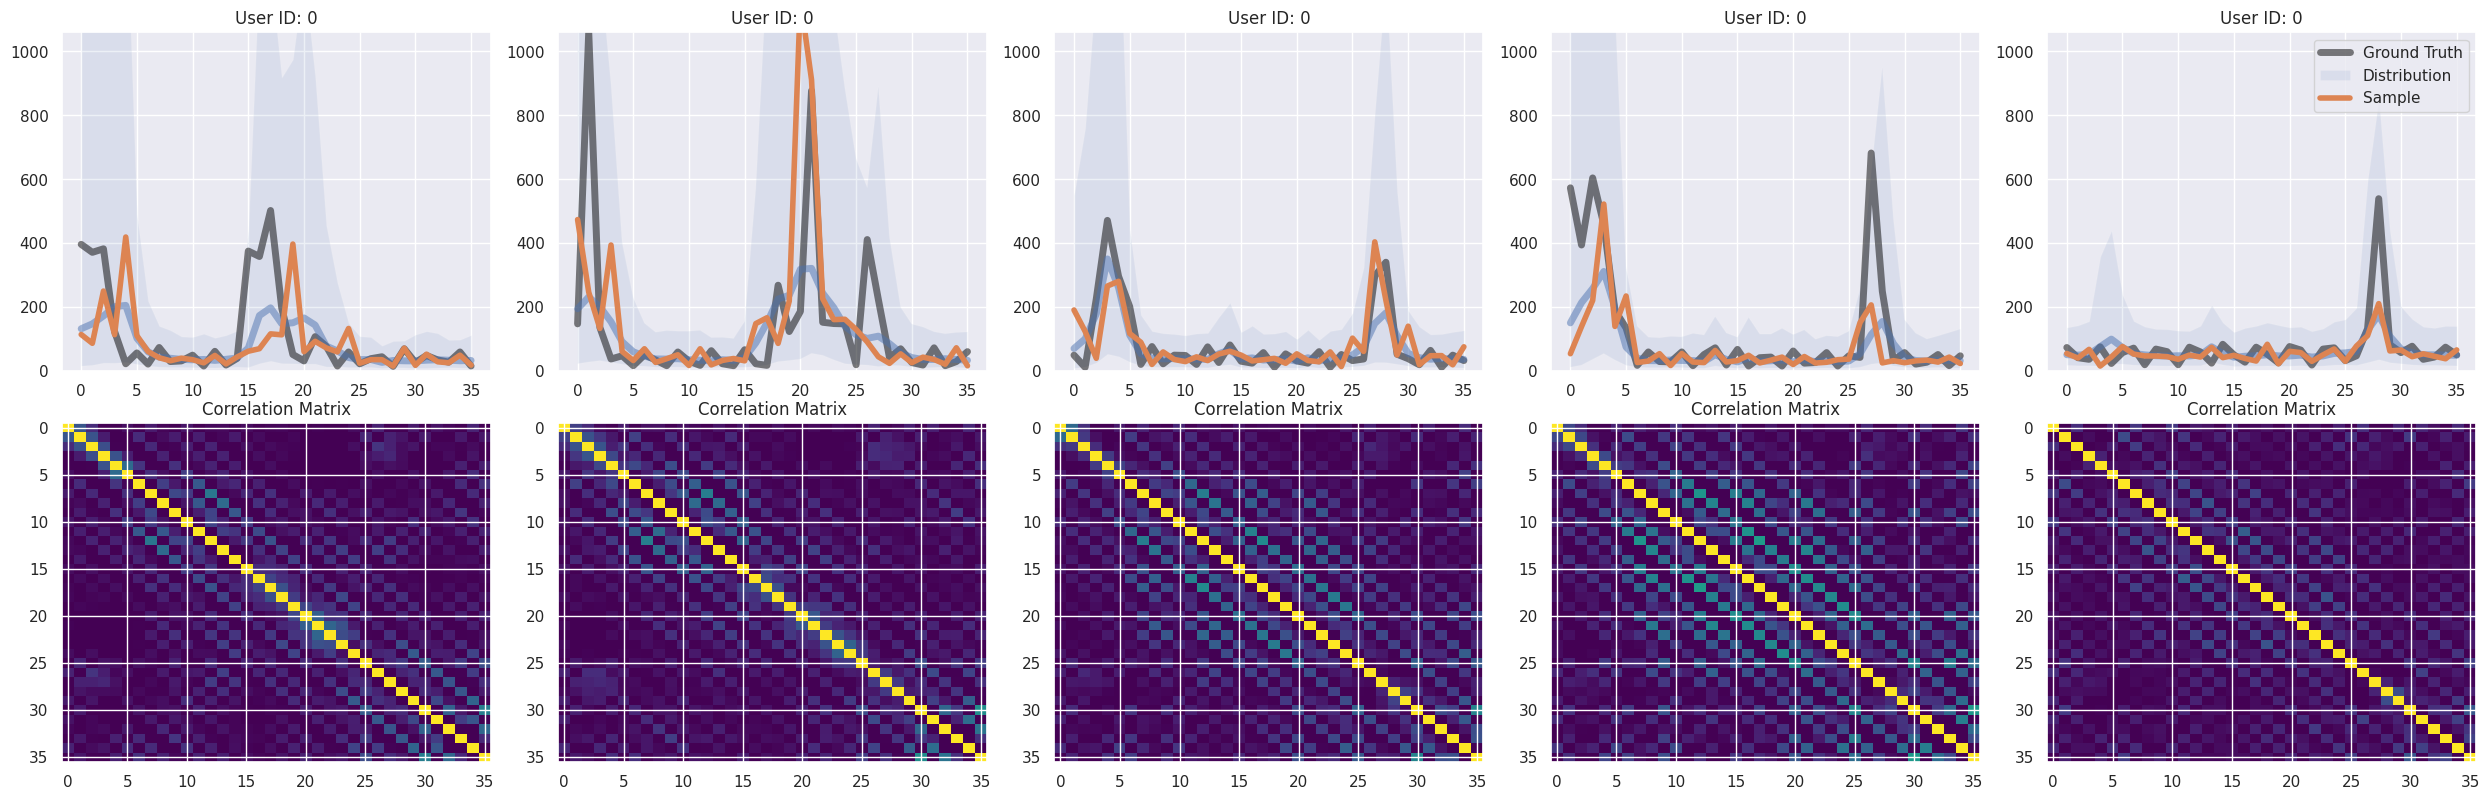

In [618]:
samples = model.decoder.sample({k: v[0,random_idx] for k, v in x_rec["params"].items()},num_samples=num_rec_samples).detach()
samples_denorm = utils.zero_preserved_log_denormalize(samples, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)

fig, ax = plt.subplots(2, 5, figsize=(25, 8))
fig.tight_layout()
for i in range(5):
    ax[0,i].plot(x_val_denorm[random_idx[i]].T, lw=5, alpha=0.5, color='black', label='Ground Truth')
    ax[0,i].plot(x_rec_denorm[random_idx[i]].T, lw=5, alpha=0.5)
    ax[0,i].fill_between(np.arange(x_val_denorm.shape[1]), x_rec_denorm_sigma_low[random_idx[i]].T, x_rec_denorm_sigma_high[random_idx[i]].T, alpha=0.1, label="Distribution")
    ax[0,i].plot(samples_denorm[:,i,:].squeeze().T, lw=4, label='Sample')
    ax[0,i].set_ylim([0, np.max(x_val_denorm[random_idx]).item()])
    ax[0,i].set_title(f"User ID: {user_ids_val[random_idx[i]]}")

    im = ax[1,i].imshow(x_val_Corr[random_idx[i]], aspect='auto', cmap='viridis', interpolation='none', vmin=0, vmax=1)
    ax[1,i].set_title(f"Correlation Matrix")
ax[0,-1].legend()
plt.show()

### Random sample

In [619]:
random_condition_set, random_conditions = conditioner.get_random_conditions(1)
random_conditions["users"] = user_gamma[[user_id_selected]]
random_condition_set =  conditioner.transform(random_conditions)

print(f"User ID: {random_user_idx}")
print(f"*"*25)
print("{:<20}{:>5}".format("Condition", "Value"))
print("="*25)
for k, v in random_conditions.items():
    print(f"{k:<20}" + " ".join([f"{x:.2f}" for x in v[0]]))

User ID: 628
*************************
Condition           Value
months              1.00
weekdays            2.00
users               0.05 0.05 0.05 178.29 0.05 0.05 0.05 0.05 22.31 0.05 0.05 160.55 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05


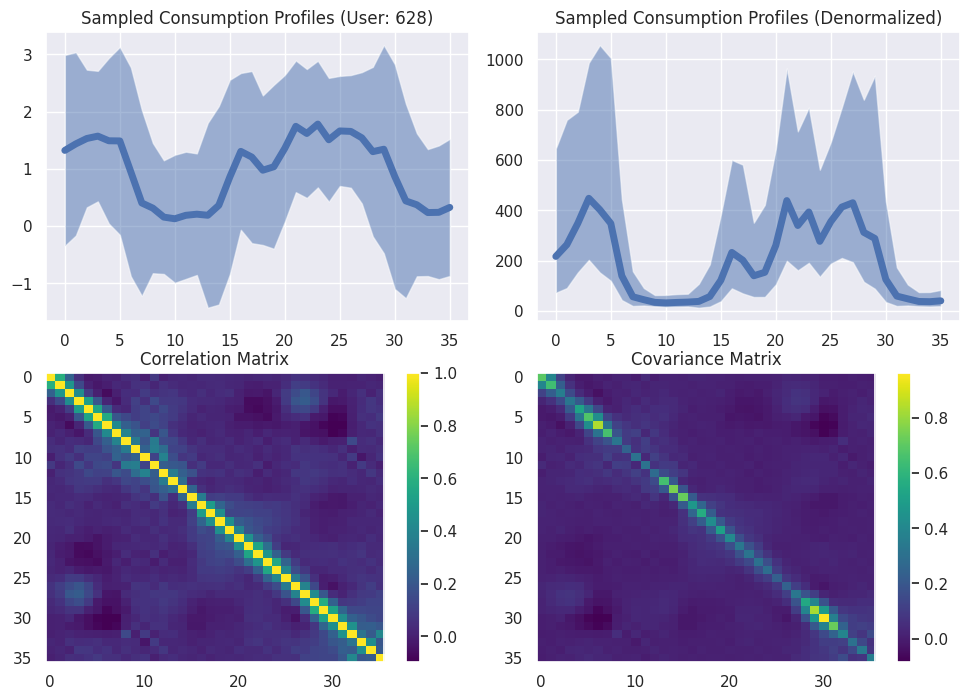

In [620]:
x_sample = model.sample(condition=torch.tensor(random_condition_set).float(), num_samples_prior=1, num_samples_likelihood=1)
x_mu = x_sample["params"]["mu"].detach()
x_sigma = model.decoder.get_marginal_sigmas(x_sample["params"]).detach()
x_mu_denorm = utils.zero_preserved_log_denormalize(x_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_sigma_upper_denorm = utils.zero_preserved_log_denormalize(x_mu+x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_sigma_lower_denorm = utils.zero_preserved_log_denormalize(x_mu-x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)
x_Sigma = model.decoder.create_covariance_matrix(x_sample["params"]).detach()
x_Corr = x_Sigma/ (x_sigma[...,None]*x_sigma[:,None,:])

fig, ax = plt.subplots(2, 2, figsize=(10, 7))
fig.tight_layout()
ax[0,0].plot(x_mu.T, lw=5)
ax[0,0].fill_between(np.arange(x_mu.shape[1]), (x_mu-2*x_sigma)[0], (x_mu+2*x_sigma)[0], alpha=0.5)
ax[0,0].set_title(f"Sampled Consumption Profiles (User: {random_user_idx})")
ax[0,1].plot(x_mu_denorm.T, lw=5)
ax[0,1].fill_between(np.arange(x_mu_denorm.shape[1]), x_sigma_lower_denorm[0], x_sigma_upper_denorm[0], alpha=0.5)
ax[0,1].set_title("Sampled Consumption Profiles (Denormalized)")
im = ax[1,0].imshow(x_Corr[0], aspect='auto', cmap='viridis', interpolation='nearest')
ax[1,0].set_title(f"Correlation Matrix")
ax[1,0].grid(False)
plt.colorbar(im)
im = ax[1,1].imshow(x_Sigma[0], aspect='auto', cmap='viridis', interpolation='none')
ax[1,1].set_title(f"Covariance Matrix")
ax[1,1].grid(False)
plt.colorbar(im)
plt.show()

#### Reconstruction Free Validation Visualisation

In [292]:
sample_val_list = [model.sample(torch.tensor(conditioner.transform(x_val_conditions)).float()[[i]]) for i in range(k)]
sample_val_mu = torch.tensor(np.array([x["params"]["mu"].detach().squeeze(0) for x in sample_val_list]))
sample_val_sigma = torch.tensor(np.array([model.decoder.get_marginal_sigmas(x["params"]).detach().squeeze(0)for x in sample_val_list]))
# sample_val_pi = torch.tensor(np.array([x["params"]["pi"].detach().squeeze(0) for x in sample_val_list]))
sample_val_pi = torch.tensor([1.0])

sample_val_rec_denorm = utils.zero_preserved_log_denormalize(sample_val_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*sample_val_pi.numpy()
sample_val_rec_denorm_sigma_low = utils.zero_preserved_log_denormalize(sample_val_mu - 2*sample_val_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*sample_val_pi.numpy()
sample_val_rec_denorm_sigma_high = utils.zero_preserved_log_denormalize(sample_val_mu + 2*sample_val_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*sample_val_pi.numpy()

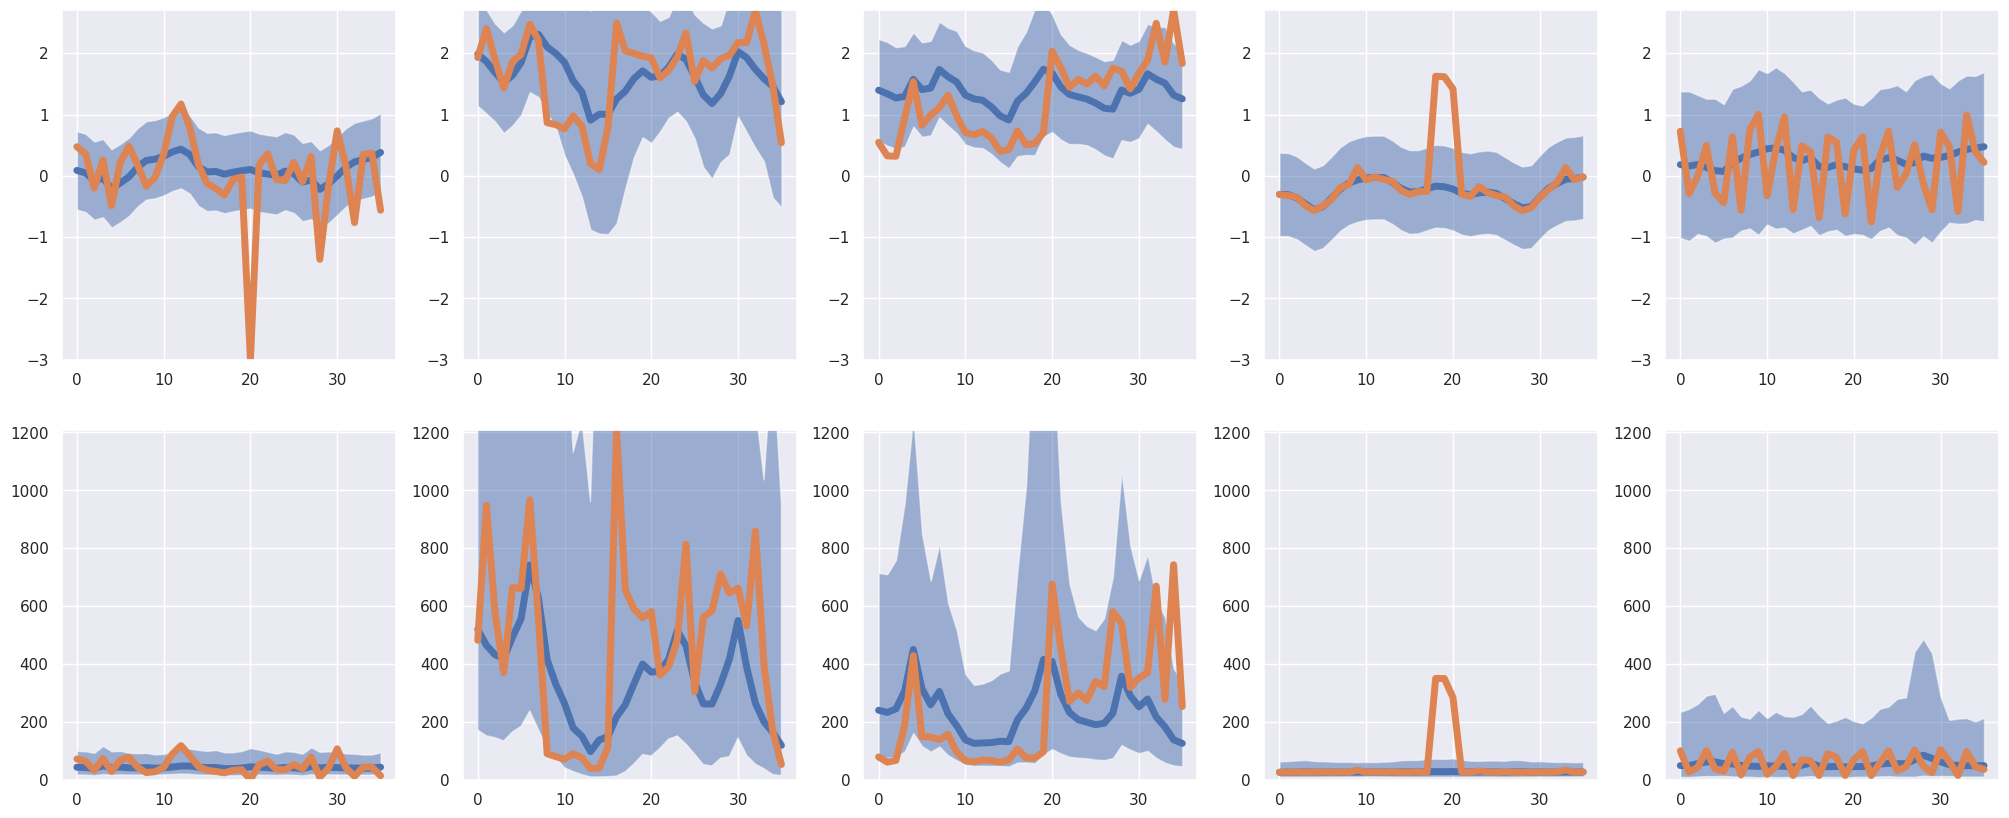

In [293]:
fig, ax = plt.subplots(2, k, figsize=(5*k, 10))

for i in range(k):
    ax[0, i].plot(sample_val_mu[i], lw=5)
    ax[0, i].fill_between(np.arange(x_val.shape[1]), (sample_val_mu-2*sample_val_sigma)[i], (sample_val_mu+2*sample_val_sigma)[i],alpha=0.5)
    ax[0, i].plot(x_val[i], lw=5)
    ax[0, i].set_ylim([torch.min(x_val).item(), torch.max(x_val).item()])

    ax[1, i].plot(sample_val_rec_denorm[i].T, lw=5)
    ax[1, i].fill_between(np.arange(x_val_denorm.shape[1]), sample_val_rec_denorm_sigma_low[i].T, sample_val_rec_denorm_sigma_high[i].T, alpha=0.5)
    ax[1, i].plot(x_val_denorm[i].T, lw=5)
    ax[1, i].set_ylim([np.min(x_val_denorm).item()*0, np.max(x_val_denorm).item()])

### Topic representatives

In [ ]:
random_conditions = conditioner.get_random_conditions(1)
print("{:<20}{:>5}".format("Condition", "Value"))
print("="*25)
for k, v in random_conditions[1].items(): print(f"{k:<20}" + " ".join([f"{x:.2f}" for x in v[0]]))

Condition           Value
months              1.00
weekdays            3.00
users               2.15 2.26 2.20 0.06 2.94 5.32 0.02 0.88 27.78 14.00 8.78 3.18 4.13 6.35 0.25 10.92 6.76 18.74 8.10 3.25


In [ ]:
for topic in range(NUM_TOPICS):
    topic_onehot = np.zeros((1, NUM_TOPICS))
    topic_onehot[0, topic] = 1.0
    random_conditions[0][0,-NUM_TOPICS:] = topic_onehot
    x_sample = model.sample(condition=torch.tensor(random_conditions[0]).float(), num_samples_prior=1, num_samples_likelihood=1)
    x_mu = x_sample["params"]["mu"].detach()
    x_sigma = x_sample["params"]["sigma"].detach()
    x_pi = x_sample["params"]["pi"].detach()
    x_mu_denorm = utils.zero_preserved_log_denormalize(x_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*x_pi.numpy()
    x_sigma_upper_denorm = utils.zero_preserved_log_denormalize(x_mu+x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*x_pi.numpy()
    x_sigma_lower_denorm = utils.zero_preserved_log_denormalize(x_mu-x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*x_pi.numpy()

    fig, ax = plt.subplots(1, 2, figsize=(10, 2))
    fig.tight_layout()
    ax[0].plot(x_mu.T, lw=5)
    ax[0].fill_between(np.arange(x_mu.shape[1]), (x_mu-x_sigma)[0], (x_mu+x_sigma)[0], alpha=0.5)
    ax[0].set_title(f"Sampled Consumption Profiles (Topic {topic})")
    ax[0].set_ylim([-1, 5])
    
    ax[1].plot(x_mu_denorm.T, lw=5)
    ax[1].fill_between(np.arange(x_mu_denorm.shape[1]), x_sigma_lower_denorm[0], x_sigma_upper_denorm[0], alpha=0.5)
    ax[1].set_title(f"Sampled Consumption Profiles (Topic {topic} Denormalized)")
    ax[1].set_ylim([0, 4000])

    plt.show()
    

KeyError: 'pi'